# Introduction

Here we are finalising the information that we would like to gather from the molecules db. Specifically, we would want tabled information for each ingredient, containing the proportions of molecules for each ingredient.

# Overview

Getting this finalised dataset entails:

- Selecting from duplicate content entries (selecting orig_foods)
- Averaging from duplicate content entries
- Aggregating final dataset

# Setup

In [1]:
#|default_exp molecule.finalise

In [2]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [3]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from food_database.molecule.join import *
from food_database.density.food_join import *

from functools import reduce

import pickle

In [4]:
#| export
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
ingredients_df = pd.read_feather('../data/local/recipe/partial/ingredients/0.feather')
expanded_ingredients_df = pd.read_feather('../data/local/recipe/partial/expanded_ingredients/0.feather')
food_df = pd.read_feather('../data/local/molecule/full/food/1_preprocessed.feather')
content_df = pd.read_feather('../data/local/molecule/full/content/1_preprocessed.feather')
compound_df = pd.read_feather('../data/local/molecule/full/compound/1_preprocessed.feather')
food_ids = pd.read_feather('../data/local/molecule/partial/food_ids/1_na_filled.feather')

ingredients_df = ingredients_df.join(food_ids)

# Selecting Duplicate Foods

As seen when exploring the database, our dataset contains contains foods which have multiple sub-entries for the foods that were grouped together to form that food entry in the various citations. We could ignore this, and simply average all the values together however the foods sometimes have vastly differing values eg. between food that is fresh, cooked, dried.

## Requirements

For each citation, select the appropriate 'orig_food_id'.

What is the most efficinet way of doing this, to minimise indexing searches for the foods. It might be that this function should return the indexes of the filters.

To begin with we can make a dataframe of the duplicate entries we have, for each food and citation.

## Creating Unique Orig Foods Series

Instead of doing this for each iteration of our function, we can make our own variable containing all the unique foods information beforehand.

In [6]:
content_df['orig_food_id'] = content_df['orig_food_id'].fillna(999999)

In [7]:
with open('../data/globals/molecule/duplicate_citations.json', 'r') as f:
    duplicate_citations = json.load(f)['duplicate_citations']
    duplicate_citations.remove('MANUAL')

In [8]:
content_df['orig_food_id'] = content_df['orig_food_id'].fillna(999999)

In [9]:
content_df.reset_index().set_index(['food_id', 'citation']).groupby(['food_id', 'citation']).cumcount()

food_id  citation   
1        MANUAL            0
         MANUAL            1
         MANUAL            2
         MANUAL            3
         MANUAL            4
                        ... 
1024     PATHBANK       3973
         PATHBANK       3974
1025     MANUAL_HAND       0
1026     MANUAL_HAND       0
         MANUAL_HAND       1
Length: 4664511, dtype: int64

In [10]:
unique_orig_foods = content_df.reset_index(drop=False)[['food_id', 'citation', 'orig_food_common_name', 'orig_food_id']].drop_duplicates()[['food_id', 'citation', 'orig_food_common_name', 'orig_food_id']]
unique_orig_foods = unique_orig_foods.reset_index(drop=False).set_index(['food_id', 'citation', 'orig_food_id']).drop('index', axis=1)
unique_orig_foods

orig_food_common_name
food_id citation        orig_food_id                            
1       MANUAL          999999                                  
        PHENOL EXPLORER 842                       angelica fresh
        PATHBANK        999999        lipid arabidopsis pathbank
        KNAPSACK        999999                                  
        PHYTOHUB        999999                                  
...                                                          ...
1023    PATHBANK        999999        lipid arabidopsis pathbank
1024    USDA            18952                 tostada shell corn
        PATHBANK        999999        lipid arabidopsis pathbank
1025    MANUAL_HAND     999999                                  
1026    MANUAL_HAND     999999                                  

[11532 rows x 1 columns]

We actually only need the citations that contain duplicates, found in the exploration chapter.

NOTE: this does however exclude some foods from the unique_orig_foods. This must be accounted for later. #TODO:

In [11]:
unique_orig_foods = unique_orig_foods[unique_orig_foods.index.get_level_values(1).isin(duplicate_citations)]

In [12]:
# setting cumulative orig_food index with respect to each food/citation
unique_orig_foods['unique_food_id'] = unique_orig_foods.groupby(['food_id', 'citation'])['orig_food_common_name'].cumcount()
unique_orig_foods = unique_orig_foods.reset_index().set_index(['food_id', 'citation', 'unique_food_id'])
unique_orig_foods

orig_food_id  \
food_id citation        unique_food_id                 
1       PHENOL EXPLORER 0                        842   
        PATHBANK        0                     999999   
4       PHENOL EXPLORER 0                        156   
        DTU             0                        465   
        USDA            0                       9148   
...                                              ...   
1023    USDA            0                      18360   
                        1                      18448   
        PATHBANK        0                     999999   
1024    USDA            0                      18952   
        PATHBANK        0                     999999   

                                                      orig_food_common_name  
food_id citation        unique_food_id                                       
1       PHENOL EXPLORER 0                                    angelica fresh  
        PATHBANK        0                        lipid arabidopsis pathbank  
4       PHENOL EXPLORER 0                                              kiwi  
        DTU             0                                    kiwi fruit raw  
        USDA            0                               kiwifruit green raw  
...                                                                     ...  
1023    USDA            0                                  taco shell baked  
                        1               taco shell baked without added salt  
        PATHBANK        0                        lipid arabidopsis pathbank  
1024    USDA            0                                tostada shell corn  
        PATHBANK        0                        lipid arabidopsis pathbank  

[10316 rows x 2 columns]

In [13]:
food_id_map = unique_orig_foods.reset_index().set_index(['food_id', 'citation', 'orig_food_id'])['unique_food_id']
food_id_map.sort_index()
food_id_map

food_id  citation         orig_food_id
1        PHENOL EXPLORER  842             0
         PATHBANK         999999          0
4        PHENOL EXPLORER  156             0
         DTU              465             0
         USDA             9148            0
                                         ..
1023     USDA             18360           0
                          18448           1
         PATHBANK         999999          0
1024     USDA             18952           0
         PATHBANK         999999          0
Name: unique_food_id, Length: 10316, dtype: int64

In [14]:
content_df = content_df.reset_index().set_index(['food_id', 'citation', 'orig_food_id']).sort_index()
content_df

source_id      food_name  \
food_id citation    orig_food_id                             
1       KNAPSACK    999999             1598       angelica   
                    999999             1599       angelica   
                    999999             1600       angelica   
                    999999             1601       angelica   
                    999999             1602       angelica   
...                                     ...            ...   
1024    USDA        18952             21595  tostada shell   
                    18952             21595  tostada shell   
1025    MANUAL_HAND 999999            15423    baking soda   
1026    MANUAL_HAND 999999            13358  baking powder   
                    999999            15423  baking powder   

                                                          source_name  \
food_id citation    orig_food_id                                        
1       KNAPSACK    999999                          4-Hydroxyderricin   
                    999999                            Xanthoangelol D   
                    999999                            Xanthoangelol E   
                    999999                              Xanthoangelol   
                    999999                            Xanthoangelol B   
...                                                               ...   
1024    USDA        18952         Fatty acids, total mono-unsaturated   
                    18952         Fatty acids, total mono-unsaturated   
1025    MANUAL_HAND 999999                  Sodium hydrogen carbonate   
1026    MANUAL_HAND 999999                    Calcium phosphate (1:1)   
                    999999                  Sodium hydrogen carbonate   

                                  concentration orig_citation  \
food_id citation    orig_food_id                                
1       KNAPSACK    999999                 <NA>          <NA>   
                    999999                 <NA>          <NA>   
                    999999                 <NA>          <NA>   
                    999999                 <NA>          <NA>   
                    999999                 <NA>          <NA>   
...                                         ...           ...   
1024    USDA        18952                7217.0          <NA>   
                    18952                8285.0          <NA>   
1025    MANUAL_HAND 999999             100000.0          <NA>   
1026    MANUAL_HAND 999999              10000.0          <NA>   
                    999999              30000.0          <NA>   

                                 orig_food_common_name orig_food_part  
food_id citation    orig_food_id                                       
1       KNAPSACK    999999                                       <NA>  
                    999999                                       <NA>  
                    999999                                       <NA>  
                    999999                                       <NA>  
                    999999                                       <NA>  
...                                                ...            ...  
1024    USDA        18952           tostada shell corn           <NA>  
                    18952           tostada shell corn           <NA>  
1025    MANUAL_HAND 999999                                       <NA>  
1026    MANUAL_HAND 999999                                       <NA>  
                    999999                                       <NA>  

[4664511 rows x 7 columns]

In [15]:
content_df = content_df.join(food_id_map)
content_df = content_df.reset_index().set_index(['food_id', 'citation', 'unique_food_id', 'source_id'])
content_df

orig_food_id      food_name  \
food_id citation    unique_food_id source_id                                
1       KNAPSACK    NaN            1598             999999       angelica   
                                   1599             999999       angelica   
                                   1600             999999       angelica   
                                   1601             999999       angelica   
                                   1602             999999       angelica   
...                                                    ...            ...   
1024    USDA        0.0            21595             18952  tostada shell   
                                   21595             18952  tostada shell   
1025    MANUAL_HAND NaN            15423            999999    baking soda   
1026    MANUAL_HAND NaN            13358            999999  baking powder   
                                   15423            999999  baking powder   

                                                                      source_name  \
food_id citation    unique_food_id source_id                                        
1       KNAPSACK    NaN            1598                         4-Hydroxyderricin   
                                   1599                           Xanthoangelol D   
                                   1600                           Xanthoangelol E   
                                   1601                             Xanthoangelol   
                                   1602                           Xanthoangelol B   
...                                                                           ...   
1024    USDA        0.0            21595      Fatty acids, total mono-unsaturated   
                                   21595      Fatty acids, total mono-unsaturated   
1025    MANUAL_HAND NaN            15423                Sodium hydrogen carbonate   
1026    MANUAL_HAND NaN            13358                  Calcium phosphate (1:1)   
                                   15423                Sodium hydrogen carbonate   

                                              concentration orig_citation  \
food_id citation    unique_food_id source_id                                
1       KNAPSACK    NaN            1598                <NA>          <NA>   
                                   1599                <NA>          <NA>   
                                   1600                <NA>          <NA>   
                                   1601                <NA>          <NA>   
                                   1602                <NA>          <NA>   
...                                                     ...           ...   
1024    USDA        0.0            21595             7217.0          <NA>   
                                   21595             8285.0          <NA>   
1025    MANUAL_HAND NaN            15423           100000.0          <NA>   
1026    MANUAL_HAND NaN            13358            10000.0          <NA>   
                                   15423            30000.0          <NA>   

                                             orig_food_common_name  \
food_id citation    unique_food_id source_id                         
1       KNAPSACK    NaN            1598                              
                                   1599                              
                                   1600                              
                                   1601                              
                                   1602                              
...                                                            ...   
1024    USDA        0.0            21595        tostada shell corn   
                                   21595        tostada shell corn   
1025    MANUAL_HAND NaN            15423                             
1026    MANUAL_HAND NaN            13358                             
                                   15423                             

                         

In [16]:
content_df = content_df.drop('orig_food_id', axis=1)
unique_orig_foods = unique_orig_foods.drop('orig_food_id', axis=1)

In [17]:
unique_orig_foods

orig_food_common_name
food_id citation        unique_food_id                                     
1       PHENOL EXPLORER 0                                    angelica fresh
        PATHBANK        0                        lipid arabidopsis pathbank
4       PHENOL EXPLORER 0                                              kiwi
        DTU             0                                    kiwi fruit raw
        USDA            0                               kiwifruit green raw
...                                                                     ...
1023    USDA            0                                  taco shell baked
                        1               taco shell baked without added salt
        PATHBANK        0                        lipid arabidopsis pathbank
1024    USDA            0                                tostada shell corn
        PATHBANK        0                        lipid arabidopsis pathbank

[10316 rows x 1 columns]

In [18]:
content_df

food_name  \
food_id citation    unique_food_id source_id                  
1       KNAPSACK    NaN            1598            angelica   
                                   1599            angelica   
                                   1600            angelica   
                                   1601            angelica   
                                   1602            angelica   
...                                                     ...   
1024    USDA        0.0            21595      tostada shell   
                                   21595      tostada shell   
1025    MANUAL_HAND NaN            15423        baking soda   
1026    MANUAL_HAND NaN            13358      baking powder   
                                   15423      baking powder   

                                                                      source_name  \
food_id citation    unique_food_id source_id                                        
1       KNAPSACK    NaN            1598                         4-Hydroxyderricin   
                                   1599                           Xanthoangelol D   
                                   1600                           Xanthoangelol E   
                                   1601                             Xanthoangelol   
                                   1602                           Xanthoangelol B   
...                                                                           ...   
1024    USDA        0.0            21595      Fatty acids, total mono-unsaturated   
                                   21595      Fatty acids, total mono-unsaturated   
1025    MANUAL_HAND NaN            15423                Sodium hydrogen carbonate   
1026    MANUAL_HAND NaN            13358                  Calcium phosphate (1:1)   
                                   15423                Sodium hydrogen carbonate   

                                              concentration orig_citation  \
food_id citation    unique_food_id source_id                                
1       KNAPSACK    NaN            1598                <NA>          <NA>   
                                   1599                <NA>          <NA>   
                                   1600                <NA>          <NA>   
                                   1601                <NA>          <NA>   
                                   1602                <NA>          <NA>   
...                                                     ...           ...   
1024    USDA        0.0            21595             7217.0          <NA>   
                                   21595             8285.0          <NA>   
1025    MANUAL_HAND NaN            15423           100000.0          <NA>   
1026    MANUAL_HAND NaN            13358            10000.0          <NA>   
                                   15423            30000.0          <NA>   

                                             orig_food_common_name  \
food_id citation    unique_food_id source_id                         
1       KNAPSACK    NaN            1598                              
                                   1599                              
                                   1600                              
                                   1601                              
                                   1602                              
...                                                            ...   
1024    USDA        0.0            21595        tostada shell corn   
                                   21595        tostada shell corn   
1025    MANUAL_HAND NaN            15423                             
1026    MANUAL_HAND NaN            13358                             
                                   15423                             

                                             orig_food_part  
food_id citation    unique_food_id source_id                 
1       KNAPSACK    NaN            1598                <NA>  
                         

In [19]:
ingredient = expanded_ingredients_df.loc[894410,	9]
ingredient[ingredient.notnull()]

name.name.nouns.0    lime
Name: (894410, 9), dtype: object

In [20]:
matched_unique_orig_foods = unique_orig_foods.loc[food_ids.loc[ingredient.name].iloc[0]]
matched_unique_orig_foods = matched_unique_orig_foods.loc['USDA']
matched_unique_orig_foods = matched_unique_orig_foods.loc[matched_unique_orig_foods.index.dropna()]
matched_unique_orig_foods

,orig_food_common_name
unique_food_id,
0,lime juice raw
1,lime raw
2,lime juice canned bottled unsweetened
3,


We could then select the best one here according to the ingredient in a similar way the dataframe was joined.

## Searching Duplicate Foods

In [21]:
#| export
def search_duplicate_food_matches(ingredient, duplicate_foods):

    ingredient = ingredient[ingredient.notnull()]

    matched_duplicate_foods = duplicate_foods
    matched_idxs = matched_duplicate_foods.index
    found_match = False

    for search_col, search_word in ingredient.items():

        current_matched_idxs = matched_duplicate_foods.index[matched_duplicate_foods.apply(fuzzy_search, args=(search_word,))]

        if not current_matched_idxs.empty:
            matched_idxs = current_matched_idxs
            found_match = True
        else:
            if not search_col.startswith('name.name.nouns'):
                pass
        
        matched_duplicate_foods = matched_duplicate_foods.loc[matched_idxs]

    if not found_match: matched_idxs = []

    return matched_duplicate_foods

In [22]:
matched_unique_orig_foods['orig_food_common_name']

unique_food_id
0                           lime juice raw
1                                 lime raw
2    lime juice canned bottled unsweetened
3                                         
Name: orig_food_common_name, dtype: string

In [23]:
searched_duplicate_foods = search_duplicate_food_matches(ingredient, matched_unique_orig_foods['orig_food_common_name'])
searched_duplicate_foods

unique_food_id
0                           lime juice raw
1                                 lime raw
2    lime juice canned bottled unsweetened
Name: orig_food_common_name, dtype: string

## Selecting from Search

In [24]:
#| export
with open(f'{root}/data/globals/default_words.json', 'r') as f:
    default_words = json.load(f)['molecule']

In [25]:
print(default_words)

['raw', 'whole', 'fresh', 'regular', 'plain', 'unflavoured', 'unenriched', 'table', 'hard', 'common', 'ripe', 'average']


In [26]:
#| export
def calculate_match_stats(match_string, ingredient_values):
    match_position = 99
    whole_match_count = 0
    match_count = 0
    name_word_count = 99
    default_word_count = 0
    match_words = match_string.split(' ')
    for i, match_word in enumerate(match_words):
        if any([v for v in ingredient_values if fuzzy_search(v, match_word)]):
            match_position = i
            match_count += 1
        if any([v for v in ingredient_values if v == match_word]):
            whole_match_count += 1
        if any([w for w in default_words if w == match_word]):
            default_word_count += 1
    name_word_count = len(match_words)
    name_word_count -= default_word_count
    return (
        match_position,
        whole_match_count,
        match_count, 
        name_word_count,
        default_word_count
    )

In [27]:
#| export
def select_from_filtered_duplicate_matches(ingredient, matches, return_df=False):

    # since we don't have any rubbish foods here, we can include all search terms of the ingredient
    ingredient_cols = ingredient.index[ingredient.notnull()]
    ingredient_values = ingredient[ingredient_cols].values

    matched_df = matches.to_frame('name')

    matched_df['match_position'], \
    matched_df['whole_match_count'], \
    matched_df['match_count'], \
    matched_df['name_word_count'], \
    matched_df['default_word_count'] = zip(*matched_df['name'].apply(calculate_match_stats, args=(ingredient_values,)))

    matched_df = matched_df.sort_values(
        ['match_position',
         'whole_match_count',
         'match_count',
         'default_word_count',
         'name_word_count',
         'unique_food_id'],
        ascending = [
            True,
            False,
            False,
            False,
            True,
            True
        ]
    )

    if return_df:
        return matched_df
    else:
        return matched_df.iloc[0].name if not matched_df.empty else pd.NA

In [28]:
select_from_filtered_duplicate_matches(ingredient, searched_duplicate_foods, True)

,name,match_position,whole_match_count,match_count,name_word_count,default_word_count
unique_food_id,,,,,,
1,lime raw,0,1,1,1,1
0,lime juice raw,0,1,1,2,1
2,lime juice canned bottled unsweetened,0,1,1,5,0


## Maximising Contents

Anothoer point to consider is what we want from our outcome. Ideally we want to pick the food with a high amount of content entries. Lets factor this into the selection process.

In [29]:
_ = content_df.loc[670.0]
sizes = _.loc['USDA'].groupby('unique_food_id').size()
sizes.apply(lambda x: x/sizes.sum()*len(sizes))

unique_food_id
0.0    1.201550
1.0    1.201550
2.0    1.182171
3.0    1.065891
4.0    0.348837
dtype: float64

In [30]:
matched_content_df = content_df.loc[food_ids.loc[ingredient.name].iloc[0]]
matched_content_df.head()

food_name source_name  concentration  \
citation unique_food_id source_id                                        
DTU      0.0            446            lime  L-Tyrosine            0.0   
                        446            lime  L-Tyrosine            0.0   
                        474            lime    L-Lysine           13.0   
                        484            lime     Glycine            0.0   
                        556            lime   L-Alanine            0.0   

                                  orig_citation orig_food_common_name  \
citation unique_food_id source_id                                       
DTU      0.0            446                <NA>              lime raw   
                        446                <NA>              lime raw   
                        474                <NA>              lime raw   
                        484                <NA>              lime raw   
                        556                <NA>              lime raw   

                                  orig_food_part  
citation unique_food_id source_id                 
DTU      0.0            446                 <NA>  
                        446                 <NA>  
                        474                 <NA>  
                        484                 <NA>  
                        556                 <NA>

In [31]:
#| export
def calculate_relative_content_sizes(citation, matched_content_df):
    matched_content_df = matched_content_df.loc[citation]
    sizes = matched_content_df.groupby('unique_food_id').size()
    total_size = sizes.sum()
    n_foods = len(sizes)
    relative_content_sizes = sizes.apply(lambda x: x/total_size*n_foods)
    return relative_content_sizes

In [32]:
calculate_relative_content_sizes('USDA', matched_content_df)

unique_food_id
0.0    1.658537
1.0    1.151220
2.0    1.073171
3.0    0.117073
dtype: float64

In [33]:
#| export
def filter_low_content_unique_foods(matched_unique_foods, citation, matched_content_df):
    relative_content_sizes = calculate_relative_content_sizes(citation, matched_content_df)
    selection = relative_content_sizes[relative_content_sizes > 2]
    if not selection.empty: relative_content_sizes = selection
    relative_content_sizes = relative_content_sizes[relative_content_sizes > 0.5]
    return matched_unique_foods.loc[relative_content_sizes.index]

In [34]:
food_ids.loc[ingredient.name].iloc[0]

53.0

In [35]:
matched_unique_orig_foods = unique_orig_foods.loc[food_ids.loc[ingredient.name].iloc[0]].loc['USDA']
selected_unique_orig_foods = matched_unique_orig_foods.loc[matched_unique_orig_foods.index.dropna()]
selected_unique_orig_foods.head()

,orig_food_common_name
unique_food_id,
0,lime juice raw
1,lime raw
2,lime juice canned bottled unsweetened
3,


In [36]:
print(matched_unique_orig_foods)
_ = filter_low_content_unique_foods(matched_unique_orig_foods, 'USDA', matched_content_df)
_

                                orig_food_common_name
unique_food_id                                       
0                                      lime juice raw
1                                            lime raw
2               lime juice canned bottled unsweetened
3                                                    


,orig_food_common_name
unique_food_id,
0,lime juice raw
1,lime raw
2,lime juice canned bottled unsweetened


## Final Function

In [37]:
#| export
def select_citation_orig_food(matched_unique_orig_foods, ingredient, matched_content_df, return_full_index=True):

    if len(matched_unique_orig_foods) == 1: return matched_unique_orig_foods.index[0][1]
    if matched_unique_orig_foods.empty: return pd.NA
    
    citation = matched_unique_orig_foods.iloc[0].name[0]
    matched_unique_orig_foods = matched_unique_orig_foods.droplevel(0)['orig_food_common_name']
    
    matched_unique_orig_foods = filter_low_content_unique_foods(matched_unique_orig_foods, citation, matched_content_df)

    if len(matched_unique_orig_foods) == 1: return matched_unique_orig_foods.index[0]

    searched_unique_local_foods = search_duplicate_food_matches(ingredient, matched_unique_orig_foods)
    selected_food = select_from_filtered_duplicate_matches(ingredient, searched_unique_local_foods)
    
    return selected_food

In [38]:
matched_unique_orig_foods = unique_orig_foods.loc[food_ids.loc[ingredient.name].iloc[0]]
matched_unique_orig_foods = matched_unique_orig_foods.loc[matched_unique_orig_foods.index.dropna()]
matched_unique_orig_foods['citation_copy'] = matched_unique_orig_foods.index.get_level_values(0)
matched_unique_orig_foods.head()

orig_food_common_name citation_copy
citation unique_food_id                                                     
DTU      0                                            lime raw           DTU
USDA     0                                      lime juice raw          USDA
         1                                            lime raw          USDA
         2               lime juice canned bottled unsweetened          USDA
DUKE     0                                                lime          DUKE

In [39]:
assert select_citation_orig_food(matched_unique_orig_foods.loc[['USDA']], ingredient, matched_content_df) == 1

In [40]:
_ = matched_unique_orig_foods.groupby('citation', observed=True).apply(select_citation_orig_food, (ingredient), (matched_content_df))
_

citation
DTU                0
DUKE               0
PATHBANK           0
PHENOL EXPLORER    0
USDA               1
dtype: int64

In [41]:
#| export
def select_from_orig_foods(matched_unique_orig_foods, ingredient, matched_content_df, return_full_index=True):
    return matched_unique_orig_foods.groupby('citation', observed=True).apply(select_citation_orig_food, (ingredient), (matched_content_df), (return_full_index))

In [42]:
assert select_from_orig_foods(matched_unique_orig_foods, ingredient, matched_content_df)['USDA'] == 1

## Full Scale

In [43]:
#| export
def full_select_duplicate_foods(ingredient, unique_orig_foods, content_df):

    food_id = ingredient['food_id']
    ingredient = ingredient.drop('food_id')
    if pd.isnull(food_id): return pd.NA
    if food_id not in unique_orig_foods.index.get_level_values(0): return pd.NA

    matched_unique_orig_foods = unique_orig_foods.loc[food_id]
    matched_content_df = content_df.loc[food_id]
    
    selected_foods = select_from_orig_foods(matched_unique_orig_foods, ingredient, matched_content_df)

    return selected_foods if not selected_foods.empty else pd.Series()

In [44]:
ingredient = expanded_ingredients_df.join(food_ids).loc[894410,	9]

In [45]:
full_select_duplicate_foods(ingredient, unique_orig_foods, content_df)

citation
DTU                0
DUKE               0
PATHBANK           0
PHENOL EXPLORER    0
USDA               1
dtype: int64

In [46]:
duplicate_content_df = content_df.loc[content_df.index.get_level_values(1).isin(duplicate_citations)]

In [47]:
selection_results = expanded_ingredients_df.join(food_ids).sample(200, random_state=1337).\
    progress_apply(full_select_duplicate_foods, axis=1, args=(unique_orig_foods, duplicate_content_df))

  0%|                                                                                                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  6%|███████████████                                                                                                                                                                                                                         | 13/200 [00:00<00:02, 84.77it/s]

 12%|█████████████████████████████                                                                                                                                                                                                           | 25/200 [00:00<00:01, 88.04it/s]

 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                                | 47/200 [00:00<00:01, 135.82it/s]

 32%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 65/200 [00:00<00:00, 145.12it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 87/200 [00:00<00:00, 168.20it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 105/200 [00:00<00:00, 134.06it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 125/200 [00:00<00:00, 149.56it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 142/200 [00:01<00:00, 108.62it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 156/200 [00:01<00:00, 104.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 169/200 [00:01<00:00, 93.51it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 189/200 [00:01<00:00, 114.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.50it/s]

## Evaluating Results

In [48]:
selection_results = selection_results[[ 'USDA', 'DUKE', 'PHENOL EXPLORER', 'DTU']]
selection_results

,citation,USDA,DUKE,PHENOL EXPLORER,DTU
recipe,ingredient,,,,
2108309,2,0.0,NaN,0.0,2.0
2189489,0,0.0,NaN,NaN,6.0
1378004,2,NaN,NaN,NaN,10.0
525644,2,<NA>,<NA>,<NA>,<NA>
982726,10,4.0,0.0,NaN,0.0
...,...,...,...,...,...
1218377,1,6.0,NaN,NaN,0.0
1609337,10,<NA>,<NA>,<NA>,<NA>
837493,0,4.0,0.0,NaN,0.0


In [49]:
def map_food_names(result):
    food_id = food_ids.loc[result.name].iloc[0]
    return pd.Series([unique_orig_foods['orig_food_common_name'].loc[food_id, citation, unique_food_id] if all([pd.notnull(x) for x in [food_id, unique_food_id]]) else pd.NA 
            for citation, unique_food_id in result.items()], index=selection_results.columns)

In [50]:
full_select_results = selection_results.apply(map_food_names, axis=1)
full_select_results = full_select_results.join(ingredients_df['name.description']).join(food_ids)\
    .join(food_df['name'], on='food_id')\
    .rename({'name': 'food_df_name', 'name.description': 'ingredient_name'}, axis=1)
full_select_results = full_select_results[list(dict.fromkeys(['ingredient_name', 'food_df_name', *full_select_results.columns]))] # reordering columns
full_select_results = full_select_results[list(dict.fromkeys(['ingredient_name', 'food_df_name', 'USDA', 'DUKE', 'PHENOL EXPLORER', 'DTU']))] # tmp

In [51]:
pd.set_option('display.max_rows', None)

In [52]:
full_select_results

,,ingredient_name,food_df_name,USDA,DUKE,PHENOL EXPLORER,DTU
recipe,ingredient,,,,,,
2108309,2,plain greek yogurt,yogurt,yogurt plain whole milk 8 gram protein per 8 o...,<NA>,soy yogurt,yoghurt
2189489,0,margarine,margarine,margarine regular hard soybean hydrogenated,<NA>,<NA>,margarine 80% fat table use vegetable fat
1378004,2,sweet italian sausage chicken sausage,chicken,<NA>,<NA>,<NA>,chicken flesh raw
525644,2,onion,onion-family vegetable,<NA>,<NA>,<NA>,<NA>
982726,10,coconut,coconut,nut coconut meat raw,coconut,<NA>,coconut meat desiccated
2049700,4,mushroom,mushroom,mushroom white raw,<NA>,<NA>,mushroom raw
1613023,9,salt,salt,salt table,<NA>,<NA>,salt table
1020744,7,salt,salt,salt table,<NA>,<NA>,salt table
782330,7,nut,nut,<NA>,<NA>,<NA>,<NA>


In [53]:
pd.reset_option('display.max_rows')

### Evaluation

A few things to note here:

- Many of the issues are due to the food_id join rather than the selection

In [54]:
issue_list = [
    ((894410,	7	), ["USDA", "DTU"])
]

### Evaluation

In [55]:
selected_issue_df = full_select_results.loc[list(list(zip(*issue_list))[0])]
selected_issue_df['issue_col'] = list(list(zip(*issue_list))[1])
selected_issue_df

,,ingredient_name,food_df_name,USDA,DUKE,PHENOL EXPLORER,DTU,issue_col
recipe,ingredient,,,,,,,
894410,7,lime juice,lime,lime juice raw,lime,lime pure juice,lime raw,"[USDA, DTU]"


In [56]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 20)

In [57]:
output = []
for search_col in ['USDA', 'DUKE', 'PHENOL EXPLORER', 'DTU']:
    df = selected_issue_df[selected_issue_df['issue_col'].apply(lambda x: search_col in x)]
    df = df.drop([c for c in ['USDA', 'DUKE', 'PHENOL EXPLORER', 'DTU'] if c != search_col], axis=1)
    selected_unique_orig_foods = unique_orig_foods[unique_orig_foods.index.get_level_values(1) == search_col]
    output.append(df.join(food_ids).reset_index().merge(unique_orig_foods[['orig_food_common_name']], on=['food_id']).drop(['food_id', 'issue_col'], axis=1))

In [58]:
output[3]

,recipe,ingredient,ingredient_name,food_df_name,DTU,orig_food_common_name
0,894410,7,lime juice,lime,lime raw,lime raw
1,894410,7,lime juice,lime,lime raw,lime juice raw
2,894410,7,lime juice,lime,lime raw,lime raw
3,894410,7,lime juice,lime,lime raw,lime juice canne...
4,894410,7,lime juice,lime,lime raw,lime
5,894410,7,lime juice,lime,lime raw,lime
6,894410,7,lime juice,lime,lime raw,
7,894410,7,lime juice,lime,lime raw,lipid arabidopsi...
8,894410,7,lime juice,lime,lime raw,lime pure juice


In [59]:
pd.reset_option('display.max_rows')

Overall these look very solid. We have a way of visualising what went wrong in the selection process, and are happy with the results.

# Averaging Duplicate Content Values

In [60]:
#| export
all_compounds = pd.Series(pd.NA, index=content_df.index.get_level_values(3).unique())

def calculate_content_averages(matched_content_df, full_content_series):
    mean_content = matched_content_df['concentration'].groupby('source_id').mean()
    return full_content_series.fillna(mean_content)

In [61]:
matched_content_df = content_df.loc[food_ids.loc[ingredient.name].iloc[0]]
matched_content_df.head()

food_name source_name  concentration  \
citation unique_food_id source_id                                        
DTU      0.0            446            lime  L-Tyrosine            0.0   
                        446            lime  L-Tyrosine            0.0   
                        474            lime    L-Lysine           13.0   
                        484            lime     Glycine            0.0   
                        556            lime   L-Alanine            0.0   

                                  orig_citation orig_food_common_name  \
citation unique_food_id source_id                                       
DTU      0.0            446                <NA>             lime raw    
                        446                <NA>             lime raw    
                        474                <NA>             lime raw    
                        484                <NA>             lime raw    
                        556                <NA>             lime raw    

                                  orig_food_part  
citation unique_food_id source_id                 
DTU      0.0            446                 <NA>  
                        446                 <NA>  
                        474                 <NA>  
                        484                 <NA>  
                        556                 <NA>

In [62]:
content_averages = calculate_content_averages(matched_content_df[['concentration']], all_compounds)
content_averages[content_averages.notnull()]

source_id
446      0.666667
474        27.375
484           5.5
556          12.0
565         0.056
           ...   
20009         2.0
2679          0.0
11869         0.0
16554    5.445714
16555    0.355714
Length: 184, dtype: object

In [63]:
content_averages[content_averages.notna()]

source_id
446      0.666667
474        27.375
484           5.5
556          12.0
565         0.056
           ...   
20009         2.0
2679          0.0
11869         0.0
16554    5.445714
16555    0.355714
Length: 184, dtype: object

In [64]:
assert matched_content_df[matched_content_df['concentration'].notna()].index.get_level_values(2).nunique() == len(content_averages[content_averages.notna()])

In [65]:
df = expanded_ingredients_df.join(food_ids)
ingredient = df.loc[894410,	9]
ingredient[ingredient.notnull()]

name.name.nouns.0    lime
food_id              53.0
Name: (894410, 9), dtype: object

In [66]:
matched_content_df.loc[('DTU', 0)]

/tmp/ipykernel_6424/4244809645.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  matched_content_df.loc[('DTU', 0)]


,food_name,source_name,concentration,orig_citation,orig_food_common_name,orig_food_part
source_id,,,,,,
446,lime,L-Tyrosine,0.0,<NA>,lime raw,<NA>
446,lime,L-Tyrosine,0.0,<NA>,lime raw,<NA>
474,lime,L-Lysine,13.0,<NA>,lime raw,<NA>
484,lime,Glycine,0.0,<NA>,lime raw,<NA>
556,lime,L-Alanine,0.0,<NA>,lime raw,<NA>
...,...,...,...,...,...,...
21950,lime,"24,25-Dihydroxyv...",0.0,<NA>,lime raw,<NA>
21981,lime,C24:0,0.0,<NA>,lime raw,<NA>
21989,lime,"7Z,10Z,13Z,16Z,1...",0.0,<NA>,lime raw,<NA>


In [67]:
def index_df(df, index):
    try:
        df = df.loc[index]
    except KeyError:
        df = pd.DataFrame(columns=df.columns)
    return df

In [68]:
def get_ingredient_contents(ingredient, duplicate_content_df, non_duplicate_content_df, all_compounds, unique_orig_foods):

    food_id = ingredient['food_id']
    if pd.isnull(food_id): return pd.NA
    ingredient = ingredient.drop('food_id')

    matched_non_duplicate_content_df = index_df(non_duplicate_content_df, food_id)
    matched_duplicate_content_df = index_df(duplicate_content_df, food_id)
    matched_unique_orig_foods = index_df(unique_orig_foods, food_id)

    if not matched_unique_orig_foods.empty:
        selected_idxs = select_from_orig_foods(matched_unique_orig_foods, ingredient, matched_duplicate_content_df, return_full_index=False)    
        selected_matched_content_df = matched_duplicate_content_df.reset_index(2).loc[list(selected_idxs.items())].set_index('source_id', append=True)
        if not matched_non_duplicate_content_df.empty:
            selected_matched_content_df = pd.concat([selected_matched_content_df, matched_non_duplicate_content_df])
    else:
        selected_matched_content_df = matched_non_duplicate_content_df

    content_averages = calculate_content_averages(selected_matched_content_df, all_compounds)
    
    return content_averages

In [69]:
duplicate_content_df = content_df[content_df.index.get_level_values(1).isin(duplicate_citations)]
non_duplicate_content_df = content_df[~content_df.index.get_level_values(1).isin(duplicate_citations)]

In [70]:
content_averages = get_ingredient_contents(ingredient, duplicate_content_df[['concentration']], non_duplicate_content_df[['concentration']], all_compounds, unique_orig_foods)

Note: the most computationally efficient method of doing this is splitting the content_df by citations which do contain duplicate foods, and those that don't. 

In [71]:
content_averages[content_averages.notna()]

source_id
446            0.0
474      31.166667
484            0.0
556            0.0
565       0.036667
           ...    
15976          7.0
15977          7.0
17350          2.0
19882          1.0
20009          2.0
Length: 169, dtype: object

In [72]:
output_df = expanded_ingredients_df.join(food_ids).progress_apply(get_ingredient_contents, args=(
        duplicate_content_df[['concentration']],
        non_duplicate_content_df[['concentration']],
        all_compounds, 
        unique_orig_foods,), 
    axis=1)

  0%|                                                                                                                                                                                                                                                | 0/2450 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                                                                                       | 7/2450 [00:00<00:39, 61.11it/s]

  1%|█▎                                                                                                                                                                                                                                     | 14/2450 [00:00<00:44, 55.13it/s]

  1%|█▉                                                                                                                                                                                                                                     | 20/2450 [00:00<00:46, 52.45it/s]

  1%|██▍                                                                                                                                                                                                                                    | 26/2450 [00:00<00:47, 51.08it/s]

  1%|███                                                                                                                                                                                                                                    | 33/2450 [00:00<00:44, 54.76it/s]

  2%|███▋                                                                                                                                                                                                                                   | 39/2450 [00:00<00:45, 53.51it/s]

  2%|████▏                                                                                                                                                                                                                                  | 45/2450 [00:00<00:46, 52.24it/s]

  2%|████▊                                                                                                                                                                                                                                  | 51/2450 [00:00<00:47, 50.61it/s]

  2%|█████▎                                                                                                                                                                                                                                 | 57/2450 [00:01<00:50, 47.11it/s]

  3%|█████▉                                                                                                                                                                                                                                 | 63/2450 [00:01<00:49, 48.49it/s]

  3%|██████▍                                                                                                                                                                                                                                | 68/2450 [00:01<00:58, 40.68it/s]

  3%|██████▉                                                                                                                                                                                                                                | 73/2450 [00:01<00:55, 42.61it/s]

  3%|███████▍                                                                                                                                                                                                                               | 79/2450 [00:01<00:53, 44.65it/s]

  3%|████████                                                                                                                                                                                                                               | 85/2450 [00:01<00:50, 46.69it/s]

  4%|████████▍                                                                                                                                                                                                                              | 90/2450 [00:01<01:00, 38.83it/s]

  4%|█████████                                                                                                                                                                                                                              | 96/2450 [00:02<00:55, 42.70it/s]

  4%|█████████▌                                                                                                                                                                                                                            | 102/2450 [00:02<00:52, 44.65it/s]

  4%|██████████▏                                                                                                                                                                                                                           | 108/2450 [00:02<00:50, 45.99it/s]

  5%|██████████▌                                                                                                                                                                                                                           | 113/2450 [00:02<00:52, 44.69it/s]

  5%|███████████                                                                                                                                                                                                                           | 118/2450 [00:02<01:00, 38.46it/s]

  5%|███████████▋                                                                                                                                                                                                                          | 124/2450 [00:02<00:54, 42.56it/s]

  5%|████████████▎                                                                                                                                                                                                                         | 131/2450 [00:02<00:49, 47.14it/s]

  6%|████████████▊                                                                                                                                                                                                                         | 137/2450 [00:02<00:48, 47.98it/s]

  6%|█████████████▎                                                                                                                                                                                                                        | 142/2450 [00:03<00:57, 40.34it/s]

  6%|█████████████▊                                                                                                                                                                                                                        | 147/2450 [00:03<01:03, 36.38it/s]

  6%|██████████████▎                                                                                                                                                                                                                       | 153/2450 [00:03<01:05, 34.94it/s]

  6%|██████████████▉                                                                                                                                                                                                                       | 159/2450 [00:03<00:58, 39.24it/s]

  7%|███████████████▍                                                                                                                                                                                                                      | 165/2450 [00:03<00:53, 42.78it/s]

  7%|████████████████                                                                                                                                                                                                                      | 171/2450 [00:03<00:50, 44.82it/s]

  7%|████████████████▌                                                                                                                                                                                                                     | 177/2450 [00:03<00:48, 47.21it/s]

  7%|█████████████████                                                                                                                                                                                                                     | 182/2450 [00:04<00:47, 47.79it/s]

  8%|█████████████████▋                                                                                                                                                                                                                    | 188/2450 [00:04<00:45, 49.18it/s]

  8%|██████████████████▏                                                                                                                                                                                                                   | 194/2450 [00:04<00:47, 47.57it/s]

  8%|██████████████████▋                                                                                                                                                                                                                   | 199/2450 [00:04<00:47, 47.61it/s]

  8%|███████████████████▏                                                                                                                                                                                                                  | 204/2450 [00:04<00:56, 39.44it/s]

  9%|███████████████████▌                                                                                                                                                                                                                  | 209/2450 [00:04<00:54, 40.99it/s]

  9%|████████████████████                                                                                                                                                                                                                  | 214/2450 [00:04<00:54, 41.23it/s]

  9%|████████████████████▌                                                                                                                                                                                                                 | 219/2450 [00:04<00:51, 43.14it/s]

  9%|█████████████████████                                                                                                                                                                                                                 | 224/2450 [00:05<00:50, 44.49it/s]

  9%|█████████████████████▍                                                                                                                                                                                                                | 229/2450 [00:05<00:48, 45.73it/s]

 10%|██████████████████████                                                                                                                                                                                                                | 235/2450 [00:05<00:46, 47.32it/s]

 10%|██████████████████████▌                                                                                                                                                                                                               | 241/2450 [00:05<00:44, 49.27it/s]

 10%|███████████████████████                                                                                                                                                                                                               | 246/2450 [00:05<00:46, 47.88it/s]

 10%|███████████████████████▌                                                                                                                                                                                                              | 251/2450 [00:05<00:55, 39.53it/s]

 10%|████████████████████████▏                                                                                                                                                                                                             | 257/2450 [00:05<00:49, 44.46it/s]

 11%|████████████████████████▌                                                                                                                                                                                                             | 262/2450 [00:05<00:57, 38.04it/s]

 11%|█████████████████████████                                                                                                                                                                                                             | 267/2450 [00:06<00:54, 39.89it/s]

 11%|█████████████████████████▌                                                                                                                                                                                                            | 272/2450 [00:06<00:51, 42.15it/s]

 11%|██████████████████████████                                                                                                                                                                                                            | 278/2450 [00:06<00:47, 45.90it/s]

 12%|██████████████████████████▋                                                                                                                                                                                                           | 284/2450 [00:06<00:45, 47.82it/s]

 12%|███████████████████████████▏                                                                                                                                                                                                          | 289/2450 [00:06<00:44, 48.06it/s]

 12%|███████████████████████████▌                                                                                                                                                                                                          | 294/2450 [00:06<00:44, 48.58it/s]

 12%|████████████████████████████                                                                                                                                                                                                          | 299/2450 [00:06<00:44, 48.00it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                         | 305/2450 [00:06<00:42, 49.89it/s]

 13%|█████████████████████████████▏                                                                                                                                                                                                        | 311/2450 [00:06<00:42, 50.80it/s]

 13%|█████████████████████████████▊                                                                                                                                                                                                        | 317/2450 [00:07<00:50, 42.55it/s]

 13%|██████████████████████████████▎                                                                                                                                                                                                       | 323/2450 [00:07<00:47, 44.87it/s]

 13%|██████████████████████████████▉                                                                                                                                                                                                       | 329/2450 [00:07<00:45, 46.82it/s]

 14%|███████████████████████████████▍                                                                                                                                                                                                      | 335/2450 [00:07<00:44, 48.02it/s]

 14%|████████████████████████████████                                                                                                                                                                                                      | 341/2450 [00:07<00:42, 50.05it/s]

 14%|████████████████████████████████▌                                                                                                                                                                                                     | 347/2450 [00:07<00:50, 41.80it/s]

 14%|█████████████████████████████████▏                                                                                                                                                                                                    | 353/2450 [00:07<00:46, 45.10it/s]

 15%|█████████████████████████████████▌                                                                                                                                                                                                    | 358/2450 [00:07<00:49, 42.56it/s]

 15%|██████████████████████████████████▏                                                                                                                                                                                                   | 364/2450 [00:08<00:46, 45.05it/s]

 15%|██████████████████████████████████▋                                                                                                                                                                                                   | 369/2450 [00:08<00:45, 45.92it/s]

 15%|███████████████████████████████████                                                                                                                                                                                                   | 374/2450 [00:08<00:44, 46.52it/s]

 15%|███████████████████████████████████▌                                                                                                                                                                                                  | 379/2450 [00:08<00:44, 46.03it/s]

 16%|████████████████████████████████████▏                                                                                                                                                                                                 | 385/2450 [00:08<00:42, 48.21it/s]

 16%|████████████████████████████████████▋                                                                                                                                                                                                 | 391/2450 [00:08<00:41, 49.75it/s]

 16%|█████████████████████████████████████▎                                                                                                                                                                                                | 397/2450 [00:08<00:59, 34.54it/s]

 16%|█████████████████████████████████████▊                                                                                                                                                                                                | 403/2450 [00:09<00:53, 38.32it/s]

 17%|██████████████████████████████████████▍                                                                                                                                                                                               | 409/2450 [00:09<00:48, 41.77it/s]

 17%|██████████████████████████████████████▉                                                                                                                                                                                               | 415/2450 [00:09<00:44, 45.30it/s]

 17%|███████████████████████████████████████▌                                                                                                                                                                                              | 421/2450 [00:09<00:43, 46.53it/s]

 17%|███████████████████████████████████████▉                                                                                                                                                                                              | 426/2450 [00:09<00:42, 47.24it/s]

 18%|████████████████████████████████████████▌                                                                                                                                                                                             | 432/2450 [00:09<00:43, 46.60it/s]

 18%|█████████████████████████████████████████                                                                                                                                                                                             | 437/2450 [00:09<00:43, 46.49it/s]

 18%|█████████████████████████████████████████▍                                                                                                                                                                                            | 442/2450 [00:09<00:45, 44.17it/s]

 18%|██████████████████████████████████████████                                                                                                                                                                                            | 448/2450 [00:09<00:43, 46.51it/s]

 19%|██████████████████████████████████████████▌                                                                                                                                                                                           | 454/2450 [00:10<00:41, 48.49it/s]

 19%|███████████████████████████████████████████                                                                                                                                                                                           | 459/2450 [00:10<00:41, 48.38it/s]

 19%|███████████████████████████████████████████▋                                                                                                                                                                                          | 465/2450 [00:10<00:40, 49.19it/s]

 19%|████████████████████████████████████████████▏                                                                                                                                                                                         | 471/2450 [00:10<00:39, 50.26it/s]

 19%|████████████████████████████████████████████▊                                                                                                                                                                                         | 477/2450 [00:10<00:37, 52.36it/s]

 20%|█████████████████████████████████████████████▎                                                                                                                                                                                        | 483/2450 [00:10<00:47, 41.38it/s]

 20%|█████████████████████████████████████████████▉                                                                                                                                                                                        | 489/2450 [00:10<00:44, 44.14it/s]

 20%|██████████████████████████████████████████████▍                                                                                                                                                                                       | 494/2450 [00:10<00:42, 45.51it/s]

 20%|██████████████████████████████████████████████▉                                                                                                                                                                                       | 500/2450 [00:11<00:41, 47.40it/s]

 21%|███████████████████████████████████████████████▌                                                                                                                                                                                      | 507/2450 [00:11<00:37, 51.25it/s]

 21%|████████████████████████████████████████████████▏                                                                                                                                                                                     | 513/2450 [00:11<00:46, 41.37it/s]

 21%|████████████████████████████████████████████████▋                                                                                                                                                                                     | 519/2450 [00:11<00:43, 44.10it/s]

 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                    | 524/2450 [00:11<00:50, 38.31it/s]

 22%|█████████████████████████████████████████████████▊                                                                                                                                                                                    | 530/2450 [00:11<00:46, 41.58it/s]

 22%|██████████████████████████████████████████████████▎                                                                                                                                                                                   | 536/2450 [00:11<00:42, 44.77it/s]

 22%|██████████████████████████████████████████████████▊                                                                                                                                                                                   | 541/2450 [00:12<00:41, 45.51it/s]

 22%|███████████████████████████████████████████████████▎                                                                                                                                                                                  | 546/2450 [00:12<00:41, 46.31it/s]

 23%|███████████████████████████████████████████████████▉                                                                                                                                                                                  | 553/2450 [00:12<00:37, 51.24it/s]

 23%|████████████████████████████████████████████████████▍                                                                                                                                                                                 | 559/2450 [00:12<00:39, 48.09it/s]

 23%|████████████████████████████████████████████████████▉                                                                                                                                                                                 | 564/2450 [00:12<00:46, 40.55it/s]

 23%|█████████████████████████████████████████████████████▌                                                                                                                                                                                | 570/2450 [00:12<00:42, 43.78it/s]

 23%|█████████████████████████████████████████████████████▉                                                                                                                                                                                | 575/2450 [00:12<00:56, 33.16it/s]

 24%|██████████████████████████████████████████████████████▌                                                                                                                                                                               | 581/2450 [00:13<00:49, 38.01it/s]

 24%|███████████████████████████████████████████████████████                                                                                                                                                                               | 586/2450 [00:13<00:46, 39.86it/s]

 24%|███████████████████████████████████████████████████████▌                                                                                                                                                                              | 592/2450 [00:13<00:42, 43.72it/s]

 24%|████████████████████████████████████████████████████████                                                                                                                                                                              | 597/2450 [00:13<00:41, 44.21it/s]

 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                             | 602/2450 [00:13<00:49, 37.00it/s]

 25%|████████████████████████████████████████████████████████▉                                                                                                                                                                             | 607/2450 [00:13<00:55, 33.16it/s]

 25%|█████████████████████████████████████████████████████████▌                                                                                                                                                                            | 613/2450 [00:13<00:48, 37.82it/s]

 25%|██████████████████████████████████████████████████████████                                                                                                                                                                            | 619/2450 [00:13<00:44, 41.17it/s]

 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                           | 624/2450 [00:14<00:50, 36.11it/s]

 26%|███████████████████████████████████████████████████████████▏                                                                                                                                                                          | 630/2450 [00:14<00:45, 40.30it/s]

 26%|███████████████████████████████████████████████████████████▊                                                                                                                                                                          | 637/2450 [00:14<00:39, 45.41it/s]

 26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 642/2450 [00:14<00:39, 45.74it/s]

 26%|████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 647/2450 [00:14<00:39, 45.90it/s]

 27%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 652/2450 [00:14<00:47, 38.02it/s]

 27%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 657/2450 [00:14<00:45, 39.78it/s]

 27%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 662/2450 [00:15<00:52, 34.05it/s]

 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 668/2450 [00:15<00:45, 39.05it/s]

 27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 673/2450 [00:15<00:43, 40.88it/s]

 28%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 678/2450 [00:15<00:41, 42.78it/s]

 28%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 684/2450 [00:15<00:38, 45.76it/s]

 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 689/2450 [00:15<00:38, 46.11it/s]

 28%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 694/2450 [00:15<00:45, 38.56it/s]

 29%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 699/2450 [00:16<00:52, 33.51it/s]

 29%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 705/2450 [00:16<00:44, 39.09it/s]

 29%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 710/2450 [00:16<00:50, 34.64it/s]

 29%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 716/2450 [00:16<00:52, 33.29it/s]

 29%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 721/2450 [00:16<00:47, 36.62it/s]

 30%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 727/2450 [00:16<00:43, 39.75it/s]

 30%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 733/2450 [00:16<00:39, 43.71it/s]

 30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 738/2450 [00:16<00:39, 43.83it/s]

 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 745/2450 [00:17<00:35, 48.71it/s]

 31%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 751/2450 [00:17<00:34, 49.72it/s]

 31%|███████████████████████████████████████████████████████████████████████                                                                                                                                                               | 757/2450 [00:17<00:33, 50.42it/s]

 31%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 763/2450 [00:17<00:41, 40.94it/s]

 31%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 769/2450 [00:17<00:38, 43.32it/s]

 32%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 774/2450 [00:17<00:47, 35.43it/s]

 32%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 780/2450 [00:17<00:42, 39.50it/s]

 32%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 785/2450 [00:18<00:47, 35.12it/s]

 32%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 791/2450 [00:18<00:42, 39.31it/s]

 33%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 797/2450 [00:18<00:38, 43.31it/s]

 33%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 803/2450 [00:18<00:36, 45.71it/s]

 33%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 809/2450 [00:18<00:35, 46.12it/s]

 33%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 814/2450 [00:18<00:35, 46.50it/s]

 33%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 820/2450 [00:18<00:33, 49.06it/s]

 34%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 827/2450 [00:18<00:30, 53.04it/s]

 34%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 833/2450 [00:19<00:38, 41.52it/s]

 34%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 839/2450 [00:19<00:35, 44.90it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 845/2450 [00:19<00:33, 47.64it/s]

 35%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 851/2450 [00:19<00:33, 48.21it/s]

 35%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 857/2450 [00:19<00:38, 41.82it/s]

 35%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 862/2450 [00:19<00:36, 43.49it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 868/2450 [00:19<00:34, 46.13it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 873/2450 [00:19<00:33, 46.41it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 879/2450 [00:20<00:32, 48.44it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 885/2450 [00:20<00:31, 50.48it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 891/2450 [00:20<00:36, 42.18it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 897/2450 [00:20<00:34, 45.07it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 903/2450 [00:20<00:32, 47.58it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 909/2450 [00:20<00:31, 48.97it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 915/2450 [00:20<00:31, 49.24it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 921/2450 [00:20<00:32, 47.34it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 926/2450 [00:21<00:37, 40.29it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 931/2450 [00:21<00:35, 42.38it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 936/2450 [00:21<00:41, 36.45it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 942/2450 [00:21<00:36, 40.85it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 947/2450 [00:21<00:35, 42.50it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 952/2450 [00:21<00:37, 39.89it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 959/2450 [00:21<00:32, 45.70it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 965/2450 [00:22<00:31, 47.67it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 971/2450 [00:22<00:30, 49.24it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 978/2450 [00:22<00:28, 52.54it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 984/2450 [00:22<00:34, 42.52it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 990/2450 [00:22<00:32, 44.33it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 996/2450 [00:22<00:31, 46.18it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1001/2450 [00:22<00:31, 46.48it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 1007/2450 [00:22<00:30, 47.84it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1012/2450 [00:23<00:30, 47.00it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1017/2450 [00:23<00:37, 38.57it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1022/2450 [00:23<00:34, 41.11it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 1028/2450 [00:23<00:32, 43.19it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1033/2450 [00:23<00:32, 43.19it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 1038/2450 [00:23<00:31, 44.26it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1043/2450 [00:23<00:38, 37.00it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1048/2450 [00:23<00:36, 38.40it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1053/2450 [00:24<00:34, 40.81it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1059/2450 [00:24<00:31, 44.40it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1065/2450 [00:24<00:29, 47.15it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1071/2450 [00:24<00:28, 48.54it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1076/2450 [00:24<00:34, 39.44it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1082/2450 [00:24<00:32, 42.63it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1088/2450 [00:24<00:30, 45.37it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1094/2450 [00:24<00:28, 47.84it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1099/2450 [00:25<00:28, 47.57it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1105/2450 [00:25<00:27, 49.67it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1111/2450 [00:25<00:26, 50.05it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1117/2450 [00:25<00:32, 40.70it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1122/2450 [00:25<00:32, 40.86it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1128/2450 [00:25<00:30, 43.55it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1133/2450 [00:25<00:29, 45.12it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1139/2450 [00:25<00:27, 48.26it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 1144/2450 [00:26<00:38, 33.89it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1150/2450 [00:26<00:33, 38.47it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1156/2450 [00:26<00:30, 42.22it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1161/2450 [00:26<00:35, 36.35it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1166/2450 [00:26<00:38, 33.77it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1172/2450 [00:26<00:33, 37.74it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1177/2450 [00:27<00:31, 40.15it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1182/2450 [00:27<00:30, 41.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1188/2450 [00:27<00:28, 44.37it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1193/2450 [00:27<00:27, 45.48it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1198/2450 [00:27<00:33, 37.31it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1204/2450 [00:27<00:29, 41.67it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1210/2450 [00:27<00:27, 44.38it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1215/2450 [00:27<00:27, 45.17it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1220/2450 [00:28<00:31, 38.53it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1226/2450 [00:28<00:29, 41.62it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1232/2450 [00:28<00:27, 44.95it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1237/2450 [00:28<00:31, 38.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1242/2450 [00:28<00:30, 39.23it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 1247/2450 [00:28<00:29, 41.46it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1253/2450 [00:28<00:26, 44.64it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1259/2450 [00:28<00:25, 47.22it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1264/2450 [00:29<00:36, 32.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1268/2450 [00:29<00:39, 29.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1274/2450 [00:29<00:34, 34.41it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1280/2450 [00:29<00:30, 38.44it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1286/2450 [00:29<00:28, 41.55it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1291/2450 [00:29<00:27, 42.73it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 1296/2450 [00:30<00:31, 37.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1301/2450 [00:30<00:28, 39.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 1306/2450 [00:30<00:27, 41.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1312/2450 [00:30<00:25, 45.10it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1317/2450 [00:30<00:24, 45.41it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1322/2450 [00:30<00:29, 38.20it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1328/2450 [00:30<00:26, 42.95it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1333/2450 [00:30<00:26, 42.25it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 1338/2450 [00:31<00:30, 36.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1344/2450 [00:31<00:27, 40.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1351/2450 [00:31<00:23, 46.49it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1356/2450 [00:31<00:24, 45.56it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1361/2450 [00:31<00:24, 43.69it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1366/2450 [00:31<00:28, 38.71it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1371/2450 [00:31<00:26, 41.11it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1376/2450 [00:31<00:25, 41.71it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1381/2450 [00:32<00:29, 36.37it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1387/2450 [00:32<00:26, 39.95it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1393/2450 [00:32<00:24, 43.09it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1399/2450 [00:32<00:23, 45.42it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1404/2450 [00:32<00:23, 44.72it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1410/2450 [00:32<00:22, 46.59it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1415/2450 [00:32<00:31, 32.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1420/2450 [00:33<00:28, 35.71it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1426/2450 [00:33<00:25, 40.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1432/2450 [00:33<00:23, 43.47it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1437/2450 [00:33<00:22, 44.44it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1442/2450 [00:33<00:22, 45.72it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1447/2450 [00:33<00:25, 39.27it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1452/2450 [00:33<00:24, 41.14it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1458/2450 [00:33<00:22, 44.30it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1464/2450 [00:34<00:25, 38.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1471/2450 [00:34<00:21, 44.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1478/2450 [00:34<00:19, 49.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1484/2450 [00:34<00:18, 51.49it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1490/2450 [00:34<00:17, 53.60it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1498/2450 [00:34<00:16, 58.95it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1505/2450 [00:34<00:16, 56.51it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1511/2450 [00:35<00:24, 38.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1517/2450 [00:35<00:22, 42.32it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1522/2450 [00:35<00:21, 44.01it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1527/2450 [00:35<00:21, 43.19it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1532/2450 [00:35<00:24, 36.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1537/2450 [00:35<00:22, 39.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1543/2450 [00:35<00:20, 44.63it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1548/2450 [00:35<00:19, 45.20it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1554/2450 [00:35<00:18, 47.54it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1560/2450 [00:36<00:18, 48.97it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1566/2450 [00:36<00:17, 49.58it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1572/2450 [00:36<00:21, 41.56it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1578/2450 [00:36<00:19, 44.17it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1584/2450 [00:36<00:18, 47.27it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1589/2450 [00:36<00:18, 47.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1595/2450 [00:36<00:17, 48.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/2450 [00:36<00:17, 49.38it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1607/2450 [00:37<00:20, 42.10it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1613/2450 [00:37<00:18, 44.09it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1618/2450 [00:37<00:21, 38.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1624/2450 [00:37<00:19, 42.61it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1630/2450 [00:37<00:18, 45.24it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1636/2450 [00:37<00:17, 47.61it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1641/2450 [00:37<00:19, 42.52it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1646/2450 [00:38<00:19, 42.07it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1652/2450 [00:38<00:21, 37.80it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1658/2450 [00:38<00:18, 42.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1664/2450 [00:38<00:17, 46.01it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1670/2450 [00:38<00:16, 46.43it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1676/2450 [00:38<00:16, 48.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1681/2450 [00:38<00:18, 41.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1687/2450 [00:38<00:16, 45.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1693/2450 [00:39<00:15, 48.18it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1699/2450 [00:39<00:15, 47.19it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1704/2450 [00:39<00:15, 46.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1711/2450 [00:39<00:14, 50.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1717/2450 [00:39<00:14, 50.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1723/2450 [00:39<00:14, 51.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1729/2450 [00:39<00:14, 50.33it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1735/2450 [00:39<00:14, 50.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1741/2450 [00:40<00:13, 51.00it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1747/2450 [00:40<00:13, 50.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1753/2450 [00:40<00:16, 41.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1758/2450 [00:40<00:16, 42.16it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1764/2450 [00:40<00:15, 44.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1770/2450 [00:40<00:14, 47.38it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1775/2450 [00:40<00:18, 36.97it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1781/2450 [00:40<00:16, 41.51it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1786/2450 [00:41<00:15, 43.09it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1792/2450 [00:41<00:14, 45.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1797/2450 [00:41<00:18, 34.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1802/2450 [00:41<00:17, 36.69it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1808/2450 [00:41<00:15, 41.39it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1814/2450 [00:41<00:13, 45.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1819/2450 [00:41<00:15, 39.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1825/2450 [00:42<00:14, 42.50it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1830/2450 [00:42<00:16, 37.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1835/2450 [00:42<00:15, 40.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1840/2450 [00:42<00:14, 41.61it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1845/2450 [00:42<00:17, 34.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1850/2450 [00:42<00:16, 37.36it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1855/2450 [00:42<00:14, 40.37it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1860/2450 [00:42<00:13, 42.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1866/2450 [00:43<00:12, 45.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1872/2450 [00:43<00:11, 49.23it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1878/2450 [00:43<00:13, 41.11it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1884/2450 [00:43<00:12, 44.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1890/2450 [00:43<00:11, 46.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1896/2450 [00:43<00:11, 49.26it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1902/2450 [00:43<00:13, 40.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1907/2450 [00:44<00:12, 41.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1912/2450 [00:44<00:12, 43.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1917/2450 [00:44<00:11, 44.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1922/2450 [00:44<00:11, 45.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1928/2450 [00:44<00:13, 38.07it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1934/2450 [00:44<00:12, 42.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1939/2450 [00:44<00:11, 43.22it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1944/2450 [00:44<00:11, 43.72it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1949/2450 [00:45<00:13, 37.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1954/2450 [00:45<00:14, 33.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1958/2450 [00:45<00:14, 34.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1963/2450 [00:45<00:13, 37.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1968/2450 [00:45<00:14, 34.37it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1973/2450 [00:45<00:13, 36.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1979/2450 [00:45<00:11, 41.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1984/2450 [00:45<00:11, 42.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1989/2450 [00:46<00:10, 43.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1995/2450 [00:46<00:09, 46.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2000/2450 [00:46<00:12, 36.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2004/2450 [00:46<00:14, 31.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2010/2450 [00:46<00:11, 37.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2015/2450 [00:46<00:12, 34.45it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2019/2450 [00:47<00:13, 31.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2024/2450 [00:47<00:11, 35.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2030/2450 [00:47<00:10, 38.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2035/2450 [00:47<00:10, 40.92it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2040/2450 [00:47<00:11, 36.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2044/2450 [00:47<00:11, 36.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2050/2450 [00:47<00:09, 40.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2055/2450 [00:47<00:10, 36.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2059/2450 [00:48<00:13, 29.98it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2064/2450 [00:48<00:11, 33.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2068/2450 [00:48<00:10, 35.07it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2074/2450 [00:48<00:09, 40.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2079/2450 [00:48<00:08, 42.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2085/2450 [00:48<00:08, 45.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2090/2450 [00:48<00:08, 44.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2095/2450 [00:48<00:07, 45.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2101/2450 [00:48<00:07, 47.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2106/2450 [00:49<00:08, 38.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2111/2450 [00:49<00:08, 39.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2117/2450 [00:49<00:07, 43.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2122/2450 [00:49<00:08, 37.38it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2127/2450 [00:49<00:08, 39.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2132/2450 [00:49<00:07, 40.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2137/2450 [00:49<00:07, 42.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2142/2450 [00:50<00:07, 43.69it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2147/2450 [00:50<00:06, 44.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2152/2450 [00:50<00:06, 45.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2157/2450 [00:50<00:07, 37.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2162/2450 [00:50<00:07, 40.34it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2167/2450 [00:50<00:08, 34.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2171/2450 [00:50<00:08, 34.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2176/2450 [00:50<00:07, 35.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2182/2450 [00:51<00:06, 40.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2187/2450 [00:51<00:07, 36.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2193/2450 [00:51<00:06, 40.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2198/2450 [00:51<00:06, 39.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2203/2450 [00:51<00:06, 35.50it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2208/2450 [00:51<00:06, 38.32it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2214/2450 [00:51<00:05, 41.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2220/2450 [00:52<00:05, 45.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2227/2450 [00:52<00:04, 49.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2233/2450 [00:52<00:04, 49.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2238/2450 [00:52<00:04, 48.99it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2244/2450 [00:52<00:04, 51.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2250/2450 [00:52<00:03, 52.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2256/2450 [00:52<00:03, 52.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2262/2450 [00:52<00:03, 52.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2268/2450 [00:52<00:03, 52.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2274/2450 [00:53<00:03, 51.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2280/2450 [00:53<00:03, 50.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2286/2450 [00:53<00:03, 51.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2292/2450 [00:53<00:03, 42.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2297/2450 [00:53<00:04, 36.72it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2303/2450 [00:53<00:03, 40.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2308/2450 [00:53<00:04, 35.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2314/2450 [00:54<00:04, 32.67it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2320/2450 [00:54<00:03, 37.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2327/2450 [00:54<00:02, 43.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2333/2450 [00:54<00:02, 45.30it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2339/2450 [00:54<00:02, 47.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2345/2450 [00:54<00:02, 38.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2450 [00:55<00:02, 35.00it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2356/2450 [00:55<00:02, 39.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2361/2450 [00:55<00:02, 41.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2366/2450 [00:55<00:02, 36.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2371/2450 [00:55<00:02, 38.58it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2376/2450 [00:55<00:02, 35.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2382/2450 [00:55<00:01, 39.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2389/2450 [00:55<00:01, 45.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2396/2450 [00:56<00:01, 42.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2401/2450 [00:56<00:01, 43.95it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2408/2450 [00:56<00:00, 47.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2413/2450 [00:56<00:00, 45.43it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2419/2450 [00:56<00:00, 48.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2425/2450 [00:56<00:00, 50.07it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2431/2450 [00:56<00:00, 41.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2437/2450 [00:56<00:00, 44.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2442/2450 [00:57<00:00, 45.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2448/2450 [00:57<00:00, 38.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2450/2450 [01:10<00:00, 38.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2450/2450 [01:23<00:00, 29.44it/s]

In [73]:
output_df.columns

Index([ 1598,  1599,  1600,  1601,  1602,  1603,  1713,  1714,  1715,  2804,
       ...
        7967,  7968, 12486, 16245, 16327, 17119, 21872,  1538,  1545, 13358],
      dtype='int64', name='source_id', length=58826)

In [74]:
output_df.columns[output_df.isna().all()]

Index([ 1598,  1599,  1600,  1601,  1602,  1603,  1713,  1714,  1715,  2804,
       ...
        7965,  7967,  7968, 12486, 16245, 16327, 17119, 21872,  1538,  1545],
      dtype='int64', name='source_id', length=57469)

For now lets drop the compounds which don't contain concentration info.

In [75]:
output_df = output_df.drop(output_df.columns[output_df.isna().all()], axis=1)

In [76]:
output_df

source_id          12477 12664 236   316         446        474         484    \
recipe  ingredient                                                              
1746116 0           <NA>  <NA>  <NA>  <NA>   27.666667       55.5   12.666667   
        1           <NA>  <NA>  <NA>  <NA>         0.0        0.0         0.0   
        2           <NA>  <NA>  <NA>  <NA>  539.666667      951.0  450.666667   
        3           <NA>  <NA>  <NA>  <NA>        <NA>       <NA>        <NA>   
        4           <NA>  <NA>  <NA>  <NA>        <NA>       <NA>        <NA>   
...                  ...   ...   ...   ...         ...        ...         ...   
931097  9           <NA>  <NA>  <NA>  <NA>        <NA>       <NA>        <NA>   
        10          <NA>  <NA>  <NA>  <NA>   39.179093  93.339491   68.446891   
        11          <NA>  <NA>  <NA>  <NA>        <NA>       <NA>        <NA>   
        12          <NA>  <NA>  <NA>  <NA>  620.714286       <NA>      1095.0   
        13          <NA>  <NA>  <NA>  <NA>        <NA>       <NA>        <NA>   

source_id                 556       565       567    ... 15516 11709 13142  \
recipe  ingredient                                   ...                     
1746116 0             20.333333  1.653333      <NA>  ...   NaN   NaN   NaN   
        1                   0.0       0.0      <NA>  ...   NaN   NaN   NaN   
        2            771.666667     1.375      <NA>  ...   NaN   NaN   NaN   
        3                  <NA>       0.0      <NA>  ...   NaN   NaN   NaN   
        4                  <NA>      <NA>      <NA>  ...   NaN   NaN   NaN   
...                         ...       ...       ...  ...   ...   ...   ...   
931097  9                  <NA>      <NA>      <NA>  ...   NaN   NaN   NaN   
        10            98.856027  3.868571  0.157406  ...   NaN   NaN   NaN   
        11                391.0      <NA>      <NA>  ...   NaN   NaN   NaN   
        12          1092.857143  0.264286      <NA>  ...   NaN   NaN   NaN   
        13                 <NA>       0.4      <NA>  ...   NaN   NaN   NaN   

source_id          16670 234   20150 29802 9651  18378 13358  
recipe  ingredient                                            
1746116 0            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        1            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        2            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        3            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        4            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...                  ...   ...   ...   ...   ...   ...   ...  
931097  9            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        10           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        11           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        12           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        13           NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2450 rows x 1357 columns]

In [77]:
assert (output_df > 1e3/1e-2).sum().sum() == 0 

## Converting

These above are using the weight concentration ratio measured in mg/100g.

# Evaluating

## Results

### NA Values

In [78]:
output_df.isna().sum(axis=0)

source_id
12477    2434
12664    2434
236      2420
316      2442
446       721
         ... 
20150    2448
29802    2448
9651     2439
18378    2441
13358    2438
Length: 1357, dtype: int64

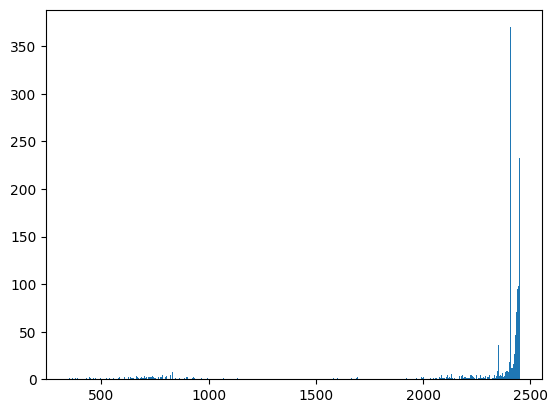

In [79]:
plt.hist(output_df.isna().sum(axis=0), bins=500);

Most of the compounds here are NA for most ingredients, which isn't necessarily a bad thing.

In [80]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4722448 entries, (1, 'KNAPSACK', nan, 1598) to (1026, 'MANUAL_HAND', nan, 15423)
Data columns (total 6 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   food_name              string 
 1   source_name            string 
 2   concentration          Float64
 3   orig_citation          string 
 4   orig_food_common_name  string 
 5   orig_food_part         string 
dtypes: Float64(1), string(5)
memory usage: 268.3+ MB


Lets check which few compounds actually are measured in most of the ingredients.

In [81]:
output_df.columns[output_df.isna().sum(axis=0) < 750]

Index([  446,   484,   556,   565,   574,   753,  1014,  1131,  1145,  1946,
        2257,  3011,  3522, 11859, 12002, 12030, 12163, 12742, 13272, 13900,
       14537,  1193,  2890,  2928,  2942,  2943,  2953,  3004,  3103,  3337,
        3513,  3524,  3583,  3637,  3716,  3730,  4288,  8052,  8323,  8425,
       10035, 12065, 12360, 12531, 12533, 12566, 12636, 12735, 12814, 13267,
       13393, 13403, 13831, 14507, 16258, 21594, 21595, 21596, 21981, 12022,
         455, 13719],
      dtype='int64', name='source_id')

In [82]:
content_df['source_name'][content_df.index.get_level_values(1).isin(output_df.columns[output_df.isna().sum(axis=0) < 750])].unique()

<StringArray>
[]
Length: 0, dtype: string

# Saving

In [83]:
output_df.to_feather('../data/local/molecule/partial/compounds/0.feather')
output_df.shape

(2450, 1357)